# US Pupulation Data Set


Este data set corresponde a la población mensual de E.U estimada en miles de personas desde enero 2011 hasta diciembre 2018.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

# Herramientas de forecasting

from statsmodels.tsa.ar_model import AR, ARResults

# Dataset

df = pd.read_csv("../../DataSets/uspopulation.csv", index_col = 'DATE', parse_dates = True)
df.index.freq = 'MS'

In [11]:
df

,PopEst
DATE,
2011-01-01,311037
2011-02-01,311189
2011-03-01,311351
2011-04-01,311522
2011-05-01,311699
...,...
2018-08-01,327698
2018-09-01,327893
2018-10-01,328077


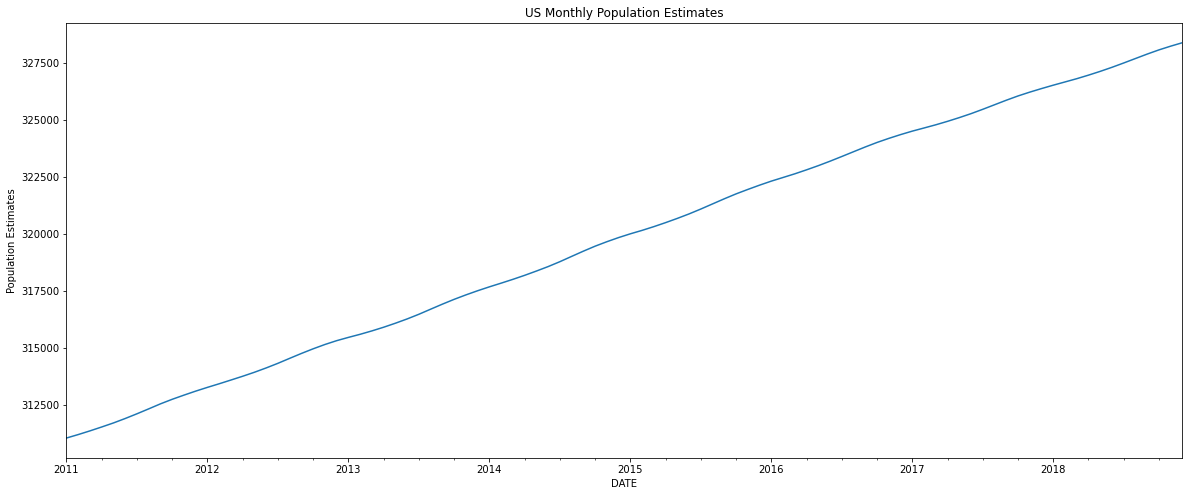

In [16]:
df.PopEst.plot(figsize = (20,8))
plt.title("US Monthly Population Estimates")
plt.ylabel('Population Estimates')
plt.show()

In [20]:
# División del Dataset

train = df.iloc[:84]
test  = df.iloc[84:]


## Model AR(I)

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
model = AR(train.PopEst)
AR1fit = model.fit(maxlag = 1, method = 'mle') # Modelos AR de orden 1
print(f'lag:{AR1fit.k_ar}')
print(f'Coefficients:\n{AR1fit.params}')

lag:1
Coefficients:
const        171.529941
L1.PopEst      0.999461
dtype: float64


In [27]:
# Predicciones con este Modelo AR


start = len(train)
end = len(train) + len(test) - 1

predictions1 = AR1fit.predict(start = start, end = end, dynamic=False).rename('AR(1) Predictions')

In [28]:
predictions1

2018-01-01    326373.619496
2018-02-01    326369.241352
2018-03-01    326364.865568
2018-04-01    326360.492143
2018-05-01    326356.121075
2018-06-01    326351.752363
2018-07-01    326347.386005
2018-08-01    326343.022001
2018-09-01    326338.660349
2018-10-01    326334.301048
2018-11-01    326329.944096
2018-12-01    326325.589493
Freq: MS, Name: AR(1) Predictions, dtype: float64

In [31]:
# Comparando predicciones con valores reales


for i in range(len(predictions1)):
    print(f"predicted={predictions1[i]}, expected = {test['PopEst'][i]}")

predicted=326373.6194955907, expected = 326527
predicted=326369.2413521753, expected = 326669
predicted=326364.8655684814, expected = 326812
predicted=326360.49214323703, expected = 326968
predicted=326356.1210751711, expected = 327134
predicted=326351.7523630131, expected = 327312
predicted=326347.3860054933, expected = 327502
predicted=326343.02200134256, expected = 327698
predicted=326338.6603492925, expected = 327893
predicted=326334.3010480754, expected = 328077
predicted=326329.94409642415, expected = 328241
predicted=326325.5894930725, expected = 328393


<AxesSubplot:xlabel='DATE'>

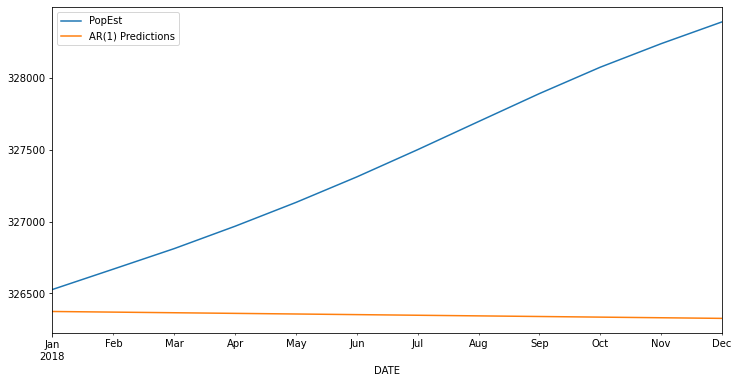

In [32]:
# Gráfica de valores predichos y estimados

test['PopEst'].plot(legend=True)
predictions1.plot(legend = True, figsize = (12,6))


El modelo no estima los datos de población estimado. Hay que agregar complejidad al modelo.

In [34]:
#Modelo AR(2)

model = AR(train.PopEst)
AR2fit = model.fit(maxlag = 2, method = 'mle') # Modelos AR de orden 2
print(f'lag:{AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')

lag:2
Coefficients:
const        136.045002
L1.PopEst      1.996649
L2.PopEst     -0.997076
dtype: float64


In [35]:

start = len(train)
end = len(train) + len(test) - 1

predictions2 = AR2fit.predict(start = start, end = end, dynamic=False).rename('AR(2) Predictions')

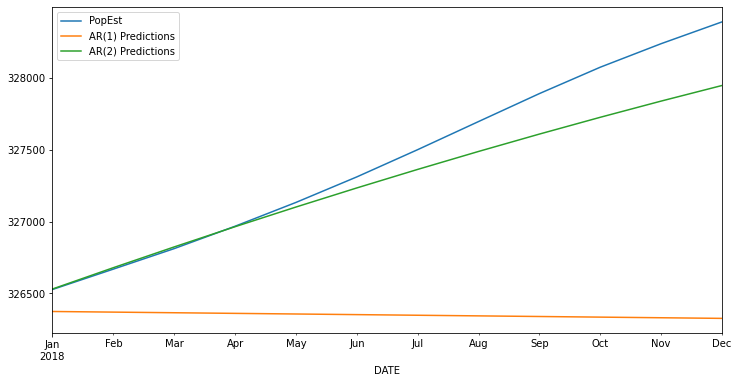

In [38]:
# Gráfica de valores predichos y estimados

test['PopEst'].plot(legend=True)
predictions1.plot(legend = True)
predictions2.plot(legend = True, figsize = (12,6))
plt.show()

El modelo con 2 retrasos se ajusta mejor que el primero. Sin embargo, podemos mejorarlo.

In [47]:
# Modelo AR(p): statsmodels elige p. La cantidad de rezagos.

model = AR(train.PopEst)
ARfit = model.fit(ic = 'bic')
print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients:\n{ARfit.params}')
print(f'p-values:\n{ARfit.pvalues}')



start = len(train)
end = len(train) + len(test) - 1

predictions8 = ARfit.predict(start = start, end = end, dynamic=False).rename('AR(8) Predictions')

Lag: 8
Coefficients:
const        82.309677
L1.PopEst     2.437997
L2.PopEst    -2.302100
L3.PopEst     1.565427
L4.PopEst    -1.431211
L5.PopEst     1.125022
L6.PopEst    -0.919494
L7.PopEst     0.963694
L8.PopEst    -0.439511
dtype: float64
p-values:
const         1.450409e-01
L1.PopEst    3.818093e-110
L2.PopEst     3.479267e-15
L3.PopEst     5.250585e-05
L4.PopEst     3.982859e-04
L5.PopEst     4.817539e-03
L6.PopEst     1.529639e-02
L7.PopEst     9.291213e-04
L8.PopEst     8.519152e-05
dtype: float64


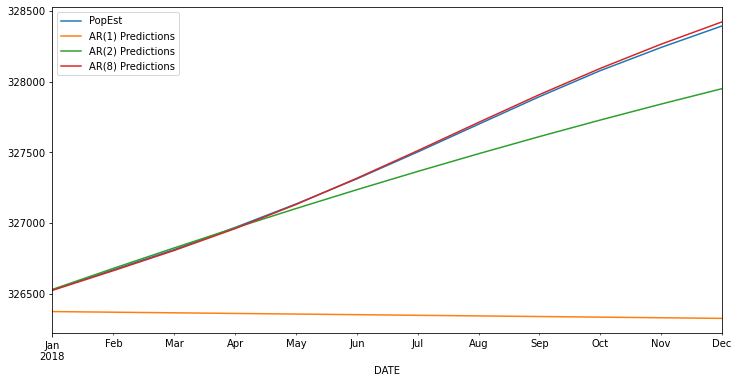

In [48]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend = True)
predictions2.plot(legend = True, figsize = (12,6))
predictions8.plot(legend = True, figsize = (12,6))

plt.show()

El nuevo modelo se ajusta mejor que los modelos anteriores.

In [52]:
# Evaluando el modelo con el error cuadrático medio (MSE)

from sklearn.metrics import mean_squared_error

labels = ['AR(1)','AR(2)','AR(8)']
predictions = [predictions1, predictions2, predictions8]

for i in range(3):
    error = mean_squared_error(test['PopEst'], predictions[i]) 
    print(f'{labels[i]} Error: {error: 11.10}')



AR(1) Error:  1563161.507
AR(2) Error:  52357.48014
AR(8) Error:  186.9694542


In [60]:
# Queremos mostrar el AIC para cada uno de los modelos

labels = ['AR(1)','AR(2)','AR(8)']
Models = [AR1fit, AR2fit, ARfit]

for i in range(3):
    print(f'{labels[i]:1.5} AIC: {Models[i].aic:5.5}')

AR(1) AIC: 10.537
AR(2) AIC: 5.1542
AR(8) AIC: 3.5878


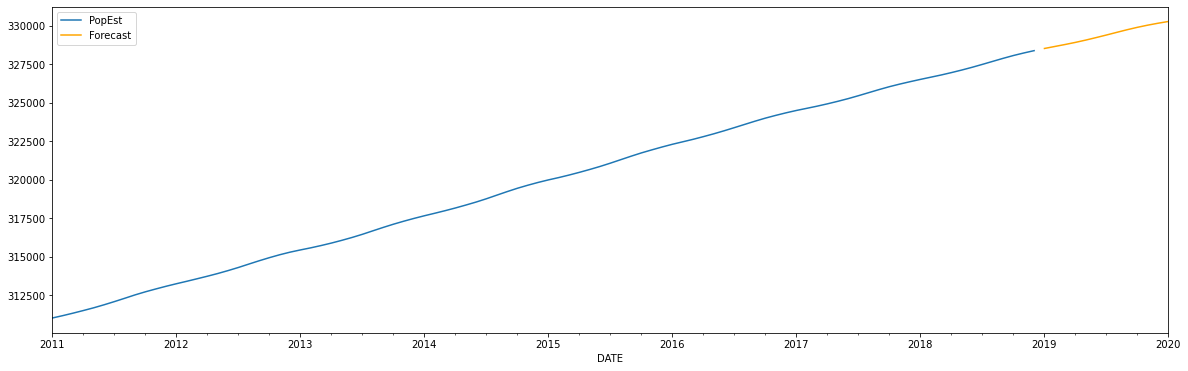

In [65]:
# Volvemos a reentranar el modelo elegido sobre el dataset  completo

model = AR(df.PopEst)


# Ajustamos el modelo
ARfit = model.fit(maxlag = 8, method = 'mle')


# Hacemos predicciones
forecast = ARfit.predict(start = len(df), end = len(df) + 12, dynamic = False).rename('Forecast')

# Gráfica de resultados
df['PopEst'].plot(legend=True)
forecast.plot(legend = True, figsize=(20,6), color = 'orange')
plt.show()

